In [19]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [20]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dict = {}
suffix, sep = 'csv', ','
for fname in glob.glob(f'./measurements/*.{suffix}'):
    with open(fname) as file:
        meas = [[float(el) for el in row.rstrip().split(sep)]
                for row in file.readlines()]
        meas_name, _ = str.rsplit(os.path.basename(fname), '.', maxsplit=1)
        meas_dict[meas_name] = np.array(meas).T

In [21]:
meas_dict.keys()

dict_keys(['through-air', 'through-si'])

In [54]:
def linear(x, k, c):
    return k*x + c

In [57]:
Ω = 1e-4/(35e-2)**2
P_e1, I_1, U_1, P_1 = meas_dict['through-air']
P_e2, I_2, U_2, P_2 = meas_dict['through-si']
P_1 = 1/Ω * P_1
P_2 = 1/Ω * P_2

par, cov = curve_fit(linear, P_e1, P_1)
k_1, c_1 = par
σ_k_1, _ = np.sqrt(np.diag(cov))
σ_P_1 = np.sqrt(np.mean((linear(P_e1, *par) - P_1)**2))

par, cov = curve_fit(linear, P_e2, P_2)
k_2, c_2 = par
σ_k_2, _ = np.sqrt(np.diag(cov))
σ_P_2 = np.sqrt(np.mean((linear(P_e2, *par) - P_2)**2))

k_1, σ_k_1, k_2, σ_k_2, σ_P_1, σ_P_2

(0.09231683973777545,
 0.002445433889104452,
 0.034318973402038155,
 0.0005351904390520761,
 0.09372985493882247,
 0.020468595427106277)

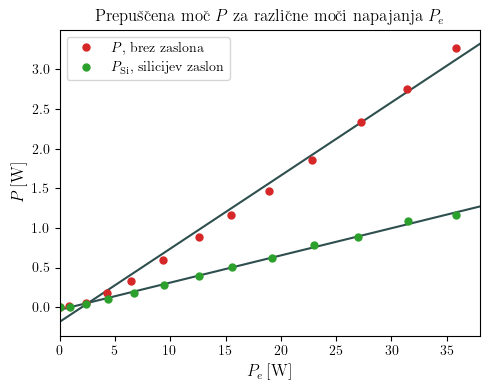

In [75]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.plot(P_e1, P_1, color='tab:red', linestyle='none',
        marker='o', markersize=5, label=r'$P$, brez zaslona')
ax.plot(P_e2, P_2, color='tab:green', linestyle='none',
        marker='o', markersize=5, label=r'$P_\mathrm{Si}$, silicijev zaslon')

P_e_lin = np.linspace(0, 38)
ax.plot(P_e_lin, linear(P_e_lin, k_1, c_1), color='darkslategrey', zorder=-1)
ax.plot(P_e_lin, linear(P_e_lin, k_2, c_2), color='darkslategrey', zorder=-1)

ax.set_title(f'Prepuščena moč $P$ za različne moči napajanja $P_e$')
ax.set_xlabel(r'$P_e\,[\mathrm{W}]$')
ax.set_ylabel(r'$P\,[\mathrm{W}]$')
ax.set_xlim(0, 38)
ax.legend()
fig.tight_layout()
fig.savefig(f'P-by-P_e.pdf')

In [87]:
σ = 5.6704e-8
k = 1.3807e-23
P_e1, I_1, U_1, P_1 = meas_dict['through-air'][:,1:]
P_e2, I_2, U_2, P_2 = meas_dict['through-si'][:,1:]
P_1 = 1/Ω * P_1
P_2 = 1/Ω * P_2
R_1 = U_1 / I_1

# Calibration for surface area at full power, where T_0 = 2700 K.
T_0, ΔT_0 = 2700, 100
P_0 = P_1[-2]
S = P_0 / (σ * T_0**4)
ΔS = 4*P_0 / (σ * T_0**5) * ΔT_0

# Temps
T_1 = (P_1 / (S*σ))**(1/4)
T_2 = (P_e2 / P_e1)**(1/4) * T_1
ΔT = np.abs(T_2 - T_1)
T = (T_1 + T_2)/2

# Fit for resistance thermal coefficient
par, cov = curve_fit(linear, T_1, R_1)
k_T, R_0 = par
σ_k_T, σ_R_0 = np.sqrt(np.diag(cov))

# Transmition ratio
t = P_2 / P_1
Δt = np.sqrt(
    (1 / P_1 * σ_P_1)**2 +
    (P_2 / P_1**2 * σ_P_2)**2
)

q_0 = 1.6022e-19
E_0 = 1.1 * q_0
def f(T, η):
    y = E_0 / (k*T)
    return η * (1 - 15/np.pi**4 * (
        -y**3 * np.log(1 - np.exp(-y)) +
        np.exp(-y) * (3*y**2 + 6*y + 6))
    )

# Fit model for η
par, cov = curve_fit(f, T, t, sigma=Δt, absolute_sigma=True)
η, = par
σ_η, = np.sqrt(np.diag(cov))

# Calc n
n = 1/η + np.sqrt(1/η**2 - 1)
Δn = (1 / η**2 + 1 / (np.sqrt(1/A**2 - 1) * A**3)) * σ_A

k_T, σ_k_T, R_0, σ_R_0, η, σ_η, n, Δn

(0.5573310171781118,
 0.009174404902817571,
 161.4309007147887,
 18.98607291788584,
 0.5253910640867502,
 0.022438083282510395,
 3.5228251909954906,
 0.17682172071166138)

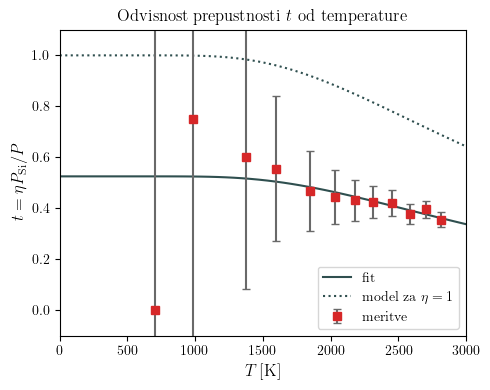

In [88]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.errorbar(T, t, yerr=Δt, color='tab:red',
            fmt='s', ecolor='dimgray', capsize=3, label='meritve')

T_lin = np.linspace(1, 3000)
ax.plot(T_lin, f(T_lin, A), color='darkslategrey', zorder=-1, label=r'fit')
ax.plot(T_lin, f(T_lin, 1), color='darkslategrey', linestyle=':', zorder=-1, label=r'model za $\eta = 1$')

ax.set_title(f'Odvisnost prepustnosti $t$ od temperature')
ax.set_xlabel(r'$T\,[\mathrm{K}]$')
ax.set_ylabel(r'$t = \eta P_\mathrm{Si}/ P$')
ax.set_xlim(0, 3000)
ax.set_ylim(-0.1, 1.1)
ax.legend()
fig.tight_layout()
fig.savefig(f't-by-T.pdf')

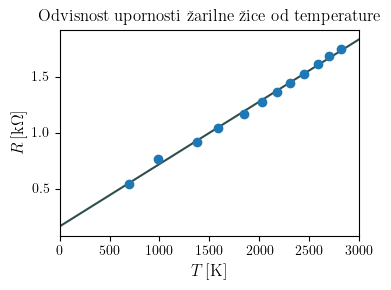

In [74]:
fig, ax = plt.subplots(1, 1, figsize=[4, 3])

ax.plot(T_1, 1e-3 * R_1, color='tab:blue', linestyle='none',
        marker='o', markersize=6)

T_lin = np.linspace(0, 3000)
ax.plot(T_lin, 1e-3 * linear(T_lin, k_T, c_T), color='darkslategrey', zorder=-1)

ax.set_title(f'Odvisnost upornosti žarilne žice od temperature')
ax.set_xlabel(r'$T\,[\mathrm{K}]$')
ax.set_ylabel(r'$R\,[\mathrm{k\Omega}]$')
ax.set_xlim(0, 3000)
fig.tight_layout()
fig.savefig(f'R-by-T.pdf')